<a href="https://colab.research.google.com/github/pidipidi/CS470_IAI_2024_Fall/blob/main/tutorial_2/RL_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 0. Setup

## Please run this tutorial on Google Chrome.

[https://www.google.com/chrome](https://www.google.com/chrome)


The tutorial may not work properly if you use a browser other than Google Chrome

In [24]:
#@title Run the following commands to install dependencies
#Install dependencies for OpenAI Gym and Stable-baselines3
!apt install swig cmake &> /dev/null
!pip install stable_baselines3 &> /dev/null
!pip install gymnasium[toy_text] &> /dev/null

#Install dependencies to visualize agents
!apt-get install -y xvfb &> /dev/null
!pip install pyvirtualdisplay scikit-video ffio pyrender &> /dev/null
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [25]:
#@title Run the following commands to define visualization tools
import numpy as np
import gymnasium as gym

import skvideo.io
from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()
def save_video_of_model(env_name, policy=None, suffix=""):
    """Record an agent behavior in an input environment"""

    env = gym.make(env_id,
              desc=None,
              map_name="4x4",
              is_slippery=False,
              max_episode_steps=100,
              render_mode="rgb_array",)
    obs = env.reset()[0]
    prev_obs = obs

    filename = env_name + suffix + ".mp4"
    output_video = skvideo.io.FFmpegWriter(filename)

    counter = 0
    done = False
    #if hasattr(env, "render_mode"):
    #    env.render_mode="rgb_array"
    while not done:
        frame = env.render()
        output_video.writeFrame(frame)

        input_obs = obs

        if policy is not None:
            action = policy(input_obs)
        else:
            action = env.action_space.sample()

        if "FrozenLake" in env_name:
            action = action.item()
        prev_obs = obs

        obs, reward, done, _, info = env.step(action)
        counter += 1

    frame = env.render()
    output_video.writeFrame(frame)
    output_video.close()
    print("Successfully saved {} frames into {}!".format(counter, filename))
    return filename

def play_video(filename, width=None):
    """Play the filename of video"""
    from IPython.display import HTML
    from base64 import b64encode

    mp4 = open(filename,'rb').read()
    data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
    source = """
    <video width=400 controls>
          <source src="%s" type="video/mp4">
    </video>
    """ % data_url
    return source


# 1. How to define a Gym instance

## a. Create a FrozenLake environment

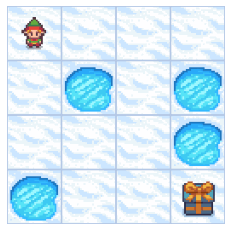

In this tutorial, we will use the FrozenLake environment from the OpenAI gym toolkit.

Frozen lake involves crossing a frozen lake from Start(S) to Goal(G) without falling into any Holes(H) by walking over the Frozen(F) lake.


You can find the details: [https://gymnasium.farama.org/environments/toy_text/frozen_lake/](https://gymnasium.farama.org/environments/toy_text/frozen_lake/)

In [26]:
import gymnasium as gym
env_id = "FrozenLake-v1"
env = gym.make(env_id,
            desc=None,
            map_name="4x4",
            is_slippery=False,
            max_episode_steps=100,
            render_mode="rgb_array")

**Observation \& Action Spaces:**
The observation of this environment is a value that represents the agent’s current position: $i\times n_{row} + j$ where $i$ and $j$ are current row and column indices, respectively. Note that the index start from 0. The range of possible observations depends on the size of the map. For example, the $4\times4$ map has 16 possible observations.



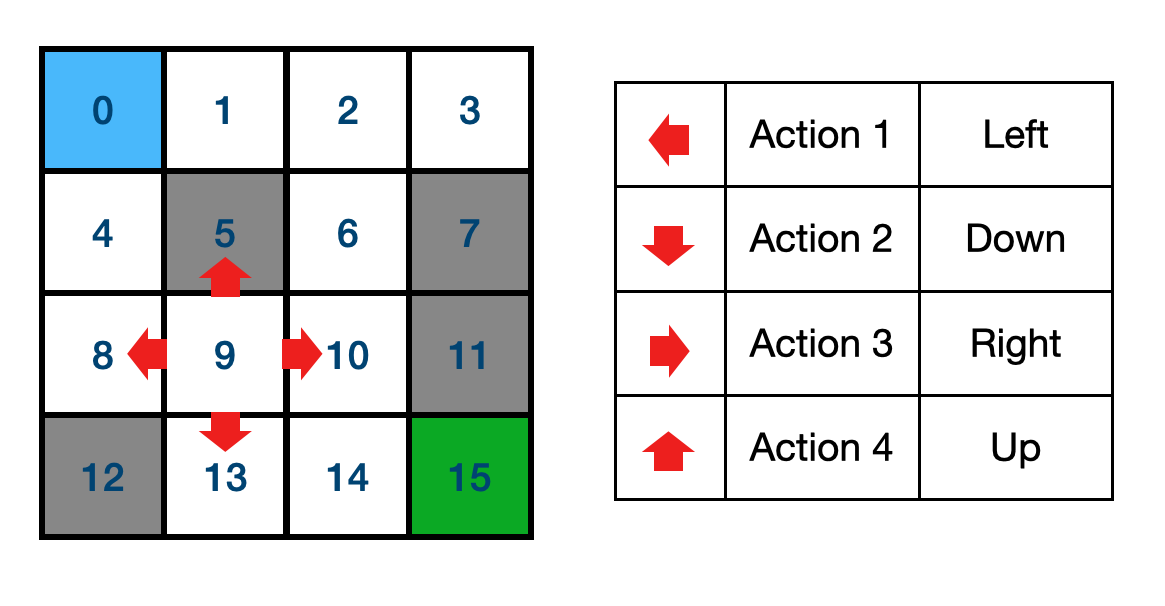


You can also check observation and action spaces using following objects, *env.observation_space* and *env.action_space*, respectively. Below explains two representative type of spaces:

*   Box: an $n$-dimensional continuous space. Our case $n$ is 2, which means a 2-D space. The space is bounded by upper and lower limits which describe the valid values our observations can take.

*   Discrete: a discrete space where {0, 1, …, n-1} are the possible values our observation or action can take.


In [27]:
print(f"Observation space of {env_id}: {env.observation_space}")
print(f"Action space of {env_id}: {env.action_space}")

Observation space of FrozenLake-v1: Discrete(16)
Action space of FrozenLake-v1: Discrete(4)


## b. Main components of the Gym environment

### reset()

The reset function let us re-initiate the environment. The re-initialization replaces the current state stored in the current environment to a new initial state and then return the new one. We generally set $s_0$ (initial state distribution) in this method.

In [28]:
env.reset(seed=47)

(0, {'prob': 1})

### render()

The render function visualizes the current environmnet. Its initial state shows the traveler agent is at the left-top corner.

Since we are using ipython interface, we would like to return and visualize an *rgb_array* through the matplotlib library.
If you are using local environment with a display, you can simply omit the argument (i.e., env.render()).
We should be aware that the rendered image is different from a state returned to us.

(-0.5, 255.5, 255.5, -0.5)

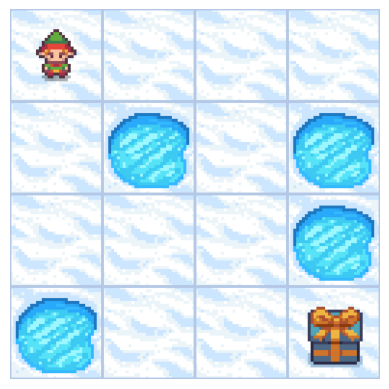

In [29]:
rgb_array = env.render()

import matplotlib.pyplot as plt
plt.imshow(rgb_array)
plt.axis('off')

### step()

The step function accepts an action, computes the observation of the environment after applying that action, and returns a tuple, (observation, reward, done, info):

*   *observation*: The new observation of the state of the environment.
*   *reward*: The reward that you can get from the environment after executing the action.
*   *done/terminated*: A boolean of whether the episode has been terminated or not.
*   *truncated*: A boolean of whether a truncation condition is satisfied or not.
*   *info*: A dictionary format of additional information depending on the environment. For example, individual reward terms. If nothing, this can be leaved as an empty dictionary ({}).



In [30]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

print( env.action_space.contains(LEFT) )
print( env.action_space.contains(4) )

True
False


In [31]:
env.step(DOWN) # equivalent to env.step(1)

(4, 0.0, False, False, {'prob': 1.0})

Passing a "Down" action multiple times, the episode terminates by falling into the hole

(-0.5, 255.5, 255.5, -0.5)

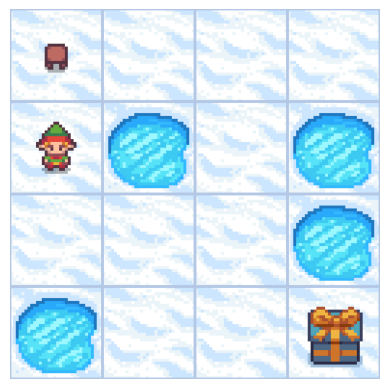

In [32]:
rgb_array = env.render()

import matplotlib.pyplot as plt
plt.imshow(rgb_array)
plt.axis('off')

# 2. How to define a policy ?

## a. Rule-based agent

We can define our own policy using predefined rules. For it, we can use a simple lookup table or an interactive keyboard input. We can also represent human demonstrations (or expert demonstrations) following this kind of predefined policies.

In [33]:
def simple_policy(state):
    LEFT = 0
    DOWN = 1
    RIGHT = 2
    UP = 3

    look_up = {
        0: [DOWN,RIGHT],
        1: [RIGHT],
        2: [DOWN],
        3: [LEFT],
        4: [DOWN],
        5: [LEFT, DOWN, RIGHT, UP],
        6: [DOWN],
        7: [LEFT, DOWN, RIGHT, UP],
        8: [RIGHT],
        9: [DOWN, RIGHT],
        10: [DOWN],
        11: [DOWN],
        12: [LEFT, DOWN, RIGHT, UP],
        13: [RIGHT],
        14: [RIGHT],
        15: [LEFT, DOWN, RIGHT, UP],
    }

    action = np.array(look_up[state])
    return np.random.choice(action)

You can test your own policy using the visualization tool we provided. Make sure that your policy takes a state as an input and returns an action.

In [34]:
save_video_of_model(env_id, policy=simple_policy)

from IPython.display import HTML
source = play_video(filename=f'{env_id}.mp4')
HTML(source)

Successfully saved 6 frames into FrozenLake-v1.mp4!


## b. Neural network-based agent

Another common way of defining a policy is the creation of an agent that can encode its own policy using a neural network. In this tutorial, we will use Stable-baselines3, a PyTorch-based reinforcement learning (RL) library, which is compatible with the OpenAI Gym interface. The library also provides State-Of-The-Art RL algorithms such as Proximal Policy Opimitzation (PPO) and Soft Actor Critic (SAC).

In this tutorial, we will use one of
<!-- *  A2C(Asynchronous Advantage Actor Critic) -->
*  PPO (Proximal Policy Opimitzation)
*  DQN (Deep Q Network)

You can find Colab tutorials for stable-baselines3: [https://stable-baselines3.readthedocs.io/en/master/guide/examples.html](https://stable-baselines3.readthedocs.io/en/master/guide/examples.html)

In [35]:
import stable_baselines3
from stable_baselines3 import PPO, DQN

######################################################################
##  You can choose your Algorithm / Environment / seed as you want  ##
######################################################################

policy_cls = PPO
env_id = "FrozenLake-v1"    # "CartPole-v0", "MountainCar-v0"
seed = 47

######################################################################
######################################################################

# Use a separate environement for evaluation
env = gym.make(env_id,
              desc=None,
              map_name="4x4",
              is_slippery=False,
              max_episode_steps=100,
              render_mode="rgb_array")
eval_env = gym.make(env_id,
              desc=None,
              map_name="4x4",
              is_slippery=False,
              max_episode_steps=100,
              render_mode="rgb_array")
env.reset(seed=seed)
eval_env.reset(seed=seed)

# Initialize Agent, which is currently an random Agent, before training
model = policy_cls(policy='MlpPolicy',      # For vision-based RL, we use 'CnnPolicy'
            env=env,
            seed=seed,
            gamma=0.9)

Stable-baselines3 provides a utility function to evaluate agent policies. Following commands evaluate a random agent on the FrozenLake environment.

In [36]:
from stable_baselines3.common.evaluation import evaluate_policy
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:0.00 +/- 0.00


In [37]:
from stable_baselines3.common.callbacks import CheckpointCallback, EveryNTimesteps, EvalCallback

rewards = []
class CB(EvalCallback):
    def _on_step(self) -> bool:
        if self.n_calls % self.eval_freq == 0:
            mean_reward, std_reward = evaluate_policy(self.model, self.eval_env, n_eval_episodes=5)
            rewards.append(mean_reward)
            print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")
        return True

cb = CB(eval_env=eval_env, eval_freq=10000)
model.learn(total_timesteps=100000, callback=cb)


mean_reward:1.00 +/- 0.00
mean_reward:1.00 +/- 0.00
mean_reward:1.00 +/- 0.00
mean_reward:1.00 +/- 0.00
mean_reward:1.00 +/- 0.00
mean_reward:1.00 +/- 0.00
mean_reward:1.00 +/- 0.00
mean_reward:1.00 +/- 0.00
mean_reward:0.00 +/- 0.00
mean_reward:1.00 +/- 0.00


You can check if, after the learning, the evaluation returns an enhanced result. If the result is not optimal, please re-run the previous cell again with a higher total_timesteps value.

In [40]:
mean_reward, std_reward = evaluate_policy(model, eval_env, n_eval_episodes=10)
print(f"mean_reward:{mean_reward:.2f} +/- {std_reward:.2f}")

mean_reward:1.00 +/- 0.00


You can visualize a policy from Stable-baselines3 as follows.

In [39]:
save_video_of_model(env_id, policy=lambda *x: model.predict(*x)[0])

from IPython.display import HTML
source = play_video(filename=f'{env_id}.mp4')
HTML(source)

Successfully saved 6 frames into FrozenLake-v1.mp4!
